# Feature Engineering Part 2

- Create features based on the macroeconomic and supply/demand data
- Create features based on the distances of HDB flats from points of interests

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt

### Populate hdb_df with feature values from the corresponding year and month in feature df

In [50]:
# feature df is assumed to have date and feature columns

def add_feature(df_house,df_feature,feature,colnum,mthly):
    
    for i in range(len(df_house)):

        # get year and month from hdb_Df
        year = df_house.iloc[i,0].year
        mth = df_house.iloc[i,0].month
        
        #print(year,mth,feature)

        if mthly:
            df_feature['date'] = pd.to_datetime(df_feature['date'])
            df_house.iloc[i,colnum] = df_feature[(df_feature.date.dt.year==year) & (df_feature.date.dt.month==mth)][feature].values[0]
        else:
            df_house.iloc[i,colnum] = df_feature[(df_feature.year==year)][feature].values[0]


In [51]:
def add_factors(hdb_df):
    # add composite leading index feature
    cli_df = pd.read_csv("../datasets/output/cli_processed.csv")
    hdb_df['cli'] = 0
    add_feature(hdb_df,cli_df,'cli',hdb_df.shape[1]-1,True)

    # add pmi feature
    pmi_df = pd.read_csv("../datasets/output/pmi_processed.csv")
    hdb_df['pmi'] = 0
    add_feature(hdb_df,pmi_df,'pmi',hdb_df.shape[1]-1,True)

    # add cpf interest rate feature
    cpf_df = pd.read_csv("../datasets/output/cpf_processed.csv")
    hdb_df['cpf_rate'] = 0
    add_feature(hdb_df,cpf_df,'cpf_rate',hdb_df.shape[1]-1,True)

    # add cpi feature
    cpi_df = pd.read_csv("../datasets/output/cpi_processed.csv")
    hdb_df['cpi'] = 0
    add_feature(hdb_df,cpi_df,'cpi',hdb_df.shape[1]-1,True)

    # add gdp growth rate feature
    gdp_df = pd.read_csv("../datasets/output/gdp_processed.csv")
    hdb_df['gdp_growth'] = 0
    add_feature(hdb_df,gdp_df,'gdp_growth',hdb_df.shape[1]-1,True)

    # add unemployment rate feature
    unemployed_df = pd.read_csv("../datasets/output/unemployed_processed.csv")
    hdb_df['unemployed_rate'] = 0
    add_feature(hdb_df,unemployed_df,'unemployed_rate',hdb_df.shape[1]-1,True)
    
    # add sibor feature
    sibor_df = pd.read_csv("../datasets/output/sibor_processed.csv")
    hdb_df['sibor_3m'] = 0
    add_feature(hdb_df,sibor_df,'sibor_3m',hdb_df.shape[1]-1,True)

    # add married feature
    married_df = pd.read_csv("../datasets/output/married_processed.csv")
    hdb_df['married'] = 0
    add_feature(hdb_df,married_df,'married',hdb_df.shape[1]-1,False)

    # add income feature
    income_df = pd.read_csv("../datasets/output/income_processed.csv")
    hdb_df['mth_income'] = 0
    add_feature(hdb_df,income_df,'mth_income',hdb_df.shape[1]-1,False)

    # add hdb price index feature
    hdb_index_df = pd.read_csv("../datasets/output/hdb_index_processed.csv")
    hdb_df['hdb_index'] = 0
    add_feature(hdb_df,hdb_index_df,'hdb_index',hdb_df.shape[1]-1,True)

    # add condo price index feature
    condo_index_df = pd.read_csv("../datasets/output/condo_index_processed.csv")
    hdb_df['condo_index'] = 0
    add_feature(hdb_df,condo_index_df,'condo_index',hdb_df.shape[1]-1,True)

    # add overall pte property price index feature
    pte_index_df = pd.read_csv("../datasets/output/pte_index_processed.csv")
    hdb_df['pte_index'] = 0
    add_feature(hdb_df,pte_index_df,'pte_index',hdb_df.shape[1]-1,True)

    # add total residents feature
    pop_df = pd.read_csv("../datasets/output/pop_processed.csv")
    hdb_df['total_residents'] = 0
    add_feature(hdb_df,pop_df,'total_residents',hdb_df.shape[1]-1,False)

    # add new flat offered feature
    bto_flat_df = pd.read_csv("../datasets/output/bto_flat_processed.csv")
    hdb_df['new_flat_offered'] = 0
    add_feature(hdb_df,bto_flat_df,'new_flat_offered',hdb_df.shape[1]-1,False)

    # add new private home offered feature
    pte_home_df = pd.read_csv("../datasets/output/new_pte_home_processed.csv")
    hdb_df['new_pte_home_offered'] = 0
    add_feature(hdb_df,pte_home_df,'new_pte_home_offered',hdb_df.shape[1]-1,True)

### Calculate distances

Based on Haversine Law

https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4

In [6]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res*1000, 2)

In [7]:
# dataframe is assumed to be lat, long and feature columns

def nearest_point(df,lat,lng):
    distances = []
    
    for h in range(len(df)):
        distances.append(
            haversine_distance(lat, lng, df.iloc[h,1], df.iloc[h,2])
        )
        
    distances.sort()
    
    return distances[:1][0]


In [16]:
def add_poi_dist(df):
        
    station_df = pd.read_csv('../datasets/poi/mrt_cleaned.csv')
    df['dist_mrt'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(station_df,df.iloc[h,61],df.iloc[h,62])

    print('MRT station completed')

    mall_df = pd.read_csv('../datasets/poi/mall_geocoded.csv')
    df['dist_mall'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(mall_df,df.iloc[h,61],df.iloc[h,62])

    print('Malls completed')

    hawker_df = pd.read_csv('../datasets/poi/hawker_centre_cleaned.csv')
    df['dist_hawker'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(hawker_df,df.iloc[h,61],df.iloc[h,62])

    print('Hawker centre completed')

    park_df = pd.read_csv('../datasets/poi/park_cleaned.csv')
    df['dist_park'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(park_df,df.iloc[h,61],df.iloc[h,62])

    print('Park completed')

    after_death_df = pd.read_csv('../datasets/poi/after_death_cleaned.csv')
    df['dist_after_death'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(after_death_df,df.iloc[h,61],df.iloc[h,62])

    print('After death completed')

    attraction_df = pd.read_csv('../datasets/poi/attraction_cleaned.csv')
    df['dist_attraction'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(attraction_df,df.iloc[h,61],df.iloc[h,62])

    print('attraction completed')

    sport_df = pd.read_csv('../datasets/poi/sport_cleaned.csv')

    # choose the 5 most commmon/popular sports facilities to measure distances
    df['dist_pool'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(sport_df[sport_df.swimming_complex==1],
                        df.iloc[h,61],df.iloc[h,62])

    print('Pool completed')

    df['dist_gym'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(sport_df[sport_df.gym==1],
                                                    df.iloc[h,61],df.iloc[h,62])

    print('gym completed')

    df['dist_tennis'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(sport_df[sport_df.tennis_centre==1],
                                                         df.iloc[h,61],df.iloc[h,62])
    print('tennis completed')

    df['dist_stadium'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(sport_df[sport_df.stadium==1],
                                                    df.iloc[h,61],df.iloc[h,62])

    print('stadium completed')

    df['dist_sports_hall'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(sport_df[sport_df.sports_hall==1],
                                                         df.iloc[h,61],df.iloc[h,62])
    print('sports hall completed')

    library_df = pd.read_csv('../datasets/poi/library_cleaned.csv')
    df['dist_library'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(library_df,df.iloc[h,61],df.iloc[h,62])

    print('library completed')

    school_df = pd.read_csv('../datasets/poi/school_geocoded.csv')
    df['dist_school'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(school_df,df.iloc[h,61],df.iloc[h,62])
        
    print('school completed')

In [17]:
five = pd.read_csv("../datasets/hdb/555.csv")

In [ ]:
school_df = pd.read_csv('../datasets/poi/school_geocoded.csv')
new['dist_school'] = 0
for h in range(len(new)):
    new.iloc[h,new.shape[1]-1] = nearest_point(school_df,new.iloc[h,61],new.iloc[h,62])

'lat'

In [51]:
add_poi_dist(six)

MRT station completed
Malls completed
Hawker centre completed
Park completed
After death completed
attraction completed
Pool completed
gym completed
tennis completed
stadium completed
sports hall completed
library completed
school completed


In [19]:
add_poi_dist(five)

MRT station completed
Malls completed
Hawker centre completed
Park completed
After death completed
attraction completed
Pool completed
gym completed
tennis completed
stadium completed
sports hall completed
library completed
school completed


In [20]:
# save as file
five.to_csv("../datasets/combined/555.csv")

In [21]:
combined = pd.read_csv("../datasets/combined/combined_2015_2018.csv")

In [23]:
combined.shape

(80405, 91)

In [52]:
five = five.drop(columns='dist_school')

In [53]:
six = six.drop(columns='dist_school')

In [54]:
five.shape

(103, 91)

In [55]:
six.shape

(1, 91)

In [58]:
base = combined[combined['dist_mrt']<100000].copy(deep=True)

In [59]:
base.shape

(80301, 91)

In [68]:
new = pd.concat([base,five,six],ignore_index=True)

In [ ]:
new.head()

In [66]:
base.rename(columns={'hawker':'dist_hawker'},inplace=True)

C:\Users\wtbha\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
1.32505,103.85476

In [46]:
combined.columns[79]

'dist_mrt'

In [40]:
combined.iloc[65624,62]=103.85476

In [43]:
six = combined[combined.index==65624]

In [35]:
nearest_point(hawker_df,1.32505,103.85476)

186.92

In [49]:
six = six.iloc[:,:79]

In [50]:
six

,sale_date,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,...,sibor_1m,sibor_3m,married,mth_income,hdb_index,condo_index,pte_index,total_residents,new_flat_offered,new_pte_home_offered
65624,5/1/2018,kallang_whampoa,3_room,10 TO 12,59.0,improved,1973,54,235000.0,77 lorong limau,...,1.385845,1.509458,2026800,4437,131.7,146.1,149.0,3994283,15811,2437


In [34]:
combined.columns

Index(['sale_date', 'town', 'flat_type', 'storey_range', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price',
       'address', 'floor_range', 'bedok', 'bishan', 'bukit_batok',
       'bukit_merah', 'bukit_panjang', 'bukit_timah', 'central_area',
       'choa_chu_kang', 'clementi', 'geylang', 'hougang', 'jurong_east',
       'jurong_west', 'kallang_whampoa', 'marine_parade', 'pasir_ris',
       'punggol', 'queenstown', 'sembawang', 'sengkang', 'serangoon',
       'tampines', 'toa_payoh', 'woodlands', 'yishun', 'model_adjoined_flat',
       'model_apartment', 'model_dbss', 'model_improved',
       'model_improved_maisonette', 'model_maisonette', 'model_model_a',
       'model_model_a2', 'model_model_a_maisonette', 'model_multi_generation',
       'model_new_generation', 'model_premium_apartment',
       'model_premium_apartment_loft', 'model_premium_maisonette',
       'model_simplified', 'model_standard', 'model_terrace', 'model_type_s1',
   

In [142]:
# Open the files saved in Feature Engineering Part 1 (Geocoding)

hdb_2015 = pd.read_csv("../datasets/hdb/hdb_resale_2015_geocoded.csv")
hdb_2016 = pd.read_csv("../datasets/hdb/hdb_resale_2016_geocoded.csv")
hdb_2017 = pd.read_csv("../datasets/hdb/hdb_resale_2017_geocoded.csv")
hdb_2018 = pd.read_csv("../datasets/hdb/hdb_resale_2018_geocoded.csv")

### Add features to HDB datasets

This will take hours. I processed one year at a time

In [ ]:
# Add macroecnomic factors as new features to HDB flat datasets
add_factors(hdb_2015)

# Calculate distances between POI and HDB flat and add the as features to HDB flat datasets
add_poi_dist(hdb_2015)

# save as file
hdb_2015.to_csv("../datasets/combined/data_2015.csv")

### Combine the 4 datasets

After features have been added to all datasets it is time to combine them for preprocessing work

In [15]:
data_2015 = pd.read_csv("../datasets/combined/data_2015.csv")
data_2016 = pd.read_csv("../datasets/combined/data_2016.csv")
data_2017 = pd.read_csv("../datasets/combined/data_2017.csv")
data_2018 = pd.read_csv("../datasets/combined/data_2018.csv")

In [16]:
# merge the datasets into one
combined = pd.concat([data_2015,data_2016,data_2017,data_2018],ignore_index=True)
combined.to_csv("../datasets/combined/combined_2015_2018.csv",index=False)

In [17]:
combined.describe()

,floor_area_sqm,lease_commence_date,remaining_lease,resale_price,floor_range,bedok,bishan,bukit_batok,bukit_merah,bukit_panjang,...,dist_hawker,dist_park,dist_after_death,dist_attraction,dist_pool,dist_gym,dist_tennis,dist_stadium,dist_sports_hall,dist_library
count,80405.000000,80405.000000,80405.000000,8.040500e+04,80405.000000,80405.000000,80405.000000,80405.000000,80405.000000,80405.000000,...,80405.000000,8.040500e+04,8.040500e+04,8.040500e+04,8.040500e+04,8.040500e+04,8.040500e+04,8.040500e+04,8.040500e+04,8.040500e+04
mean,97.581557,1992.077197,74.015546,4.399488e+05,7.430794,0.060058,0.019551,0.039077,0.038816,0.035296,...,1153.316828,1.556909e+04,1.939036e+04,1.743459e+04,1.615173e+04,1.637717e+04,1.819368e+04,1.665706e+04,1.638795e+04,1.596172e+04
std,24.242844,11.547896,11.518088,1.457353e+05,5.602465,0.237597,0.138452,0.193780,0.193157,0.184529,...,1816.462424,4.123750e+05,4.122225e+05,4.122466e+05,4.123578e+05,4.123500e+05,4.122894e+05,4.123405e+05,4.123497e+05,4.124073e+05
min,31.000000,1966.000000,47.000000,1.600000e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.311000e+01,6.104000e+01,1.507000e+01,1.226000e+01,1.226000e+01,3.022000e+01,3.022000e+01,1.226000e+01,2.037000e+01
25%,76.000000,1984.000000,66.000000,3.380000e+05,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,359.750000,4.812400e+02,2.196710e+03,1.473330e+03,8.153400e+02,9.404300e+02,1.608110e+03,1.000470e+03,9.502500e+02,7.358400e+02
50%,96.000000,1992.000000,73.000000,4.090000e+05,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,763.220000,7.187000e+02,3.461760e+03,2.402940e+03,1.229430e+03,1.427180e+03,3.109950e+03,1.645840e+03,1.435150e+03,1.100520e+03
75%,112.000000,2001.000000,83.000000,5.050000e+05,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1576.650000,9.998100e+02,6.762180e+03,3.518610e+03,1.798950e+03,2.083290e+03,5.102270e+03,2.629330e+03,2.098440e+03,1.611450e+03
max,280.000000,2016.000000,97.000000,1.185000e+06,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,417372.390000,1.152970e+07,1.152890e+07,1.152791e+07,1.152979e+07,1.152979e+07,1.152979e+07,1.152979e+07,1.152979e+07,1.153099e+07


In [33]:
combined[combined['dist_hawker']>5000][['sale_date','address','lat','lng']]

,sale_date,address,lat,lng
65624,5/1/2018,77 lorong limau,3.985081,101.011362


In [ ]:
hawker_df = pd.read_csv('../datasets/output/hawker_centre_processed.csv')

for h in range(len(df)):
    df.iloc[h,df.shape[1]-1] = nearest_point(hawker_df,df.iloc[h,61],df.iloc[h,62])

In [24]:
hawker_df = pd.read_csv('../datasets/poi/hawker_centre_cleaned.csv')

In [35]:
nearest_point(hawker_df,1.32505,103.85476)

186.92

In [36]:
for h in range(len(hawker_df)):
    print(hawker_df.iloc[h,0],haversine_distance(1.32505,103.85476, hawker_df.iloc[h,1], hawker_df.iloc[h,2]))


Adam Road Food Centre 4514.11
Aljunied Ave 2 Blk 117 (Blk 117 Aljunied Market and Food Centre) 3626.52
Ang Mo Kio Ave 1 Blk 226D (Kebun Baru Market and Food Centre) 4970.28
Ang Mo Kio Ave 1 Blk 341 (Teck Ghee Court) 4408.46
Ang Mo Kio Ave 10 Blk 409 (Teck Ghee Square) 4190.39
Ang Mo Kio Ave 10 Blk 453A (Chong Boon Market and Food Centre) 4812.79
Hougang Street 21 Blk 209 (Kovan Hougang Market and Food Centre) 5130.31
Jalan Batu Blk 4A (Blk 4A Jalan Batu Hawker Centre/Market) 4108.21
Jalan Bukit Merah Blk 112 (Blk 112 Jalan Bukit Merah Market and Food Centre) 5931.75
Ang Mo Kio Ave 6 Blk 724 (Blk 724 Ang Mo Kio Market) 5305.19
Beo Crescent Market 5087.48
Buffalo Road Blk 665 (Tekka Centre/Zhu Jiao Market) 2145.86
Bukit Merah Central Blk 163 (Bukit Merah Central Food Centre) 6214.43
Bukit Merah View Blk 115 (Blk 115 Bukit Merah View Market and Food Centre) 5705.98
Bukit Panjang Hawker Centre 10898.46
Bukit Timah Market 8926.06
Amoy Street Food Centre (Telok Ayer Food Centre) 5178.82
Bedo

In [4]:
df = pd.read_csv("../datasets/final/combined_all_columns.csv")

In [8]:
df['sale_date'] = pd.to_datetime(df['sale_date'])

In [2]:
hdb_df.shape

NameError: name 'hdb_df' is not defined

In [70]:
test_df.to_csv("../datasets/hdb/test_df.csv",index=False)

test_df['sale_date'] = pd.to_datetime(test_df['sale_date'])

In [69]:
add_poi_dist(test_df)

MRT station completed
Malls completed
Hawker centre completed
Park completed
After death completed
attraction completed
Pool completed
gym completed
tennis completed
stadium completed
sports hall completed
library completed


In [143]:
hdb_df.shape

(80405, 63)

In [4]:
hdb_df.to_csv("../datasets/hdb/hdb_2015_2018_addedfeature.csv",index=False)

In [144]:
hdb_df.head()

,sale_date,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,...,model_type_s1,model_type_s2,type_2_room,type_3_room,type_4_room,type_5_room,type_executive,type_multi_generation,lat,lng
0,1/1/2015,bukit_merah,4_room,04 TO 06,91.0,model_a,2001,85,680000.0,120 kim tian place,...,0,0,0,0,1,0,0,0,1.282926,103.827921
1,1/1/2015,bukit_merah,5_room,16 TO 18,115.0,improved,2001,85,842000.0,121 kim tian place,...,0,0,0,0,0,1,0,0,1.282776,103.828555
2,1/1/2015,woodlands,5_room,04 TO 06,110.0,premium_apartment,2004,88,418000.0,689c woodlands drive 75,...,0,0,0,0,0,1,0,0,1.444873,103.808449
3,1/1/2015,woodlands,5_room,10 TO 12,110.0,premium_apartment,2004,88,433000.0,689c woodlands drive 75,...,0,0,0,0,0,1,0,0,1.444873,103.808449
4,1/1/2015,woodlands,5_room,10 TO 12,110.0,premium_apartment,2004,88,440000.0,689d woodlands drive 75,...,0,0,0,0,0,1,0,0,1.444284,103.808721


In [7]:
hdb_df = pd.read_csv("../datasets/final/hdb_2015_2018_final.csv")

### Final Preprocessing before Modeling

- Remove remaining non-numeric features
- Remove highly correlated features

In [77]:
def high_corr_features(df,pos_thres,neg_thres):
    # get the pairwise correlation of oll columns in the dataframes
    corr = df.corr()

    # loop through the dataframe to find the lowest and higher correlation numbers 
    # Correlation between the same feature will be Ones, so those will be skipped

    maxx=0
    minn=0
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i != j:
                if corr.iloc[i,j]>0:
                    if corr.iloc[i,j]>maxx:
                        maxx=corr.iloc[i,j]
                        if maxx >= pos_thres:
                            print('Features that are highly positve correlated:',corr.index[i],corr.columns[j],maxx)
                else:
                    if corr.iloc[i,j]<minn:
                        minn=corr.iloc[i,j]
                        if minn <= neg_thres:
                            print('Features that are highly negative correlated:',corr.index[i],corr.columns[j],minn)


    print('Lowest negative correlation between features:',minn)
    print('Highest positive correlation between features:',maxx)

In [74]:
high_corr_features(hdb_df,0.7,-0.7)

Words that are highly negative correlated: floor_area_sqm type_3_room -0.7054084688676528
Words that are highly positve correlated: model_multi_generation type_multi_generation 1.0
Words that are highly negative correlated: cli hdb_index -0.9249408742429931
Words that are highly negative correlated: mth_income hdb_index -0.9611379557892475
Lowest negative correlation between features: -0.9611379557892475
Highest positive correlation between features: 1.0


In [75]:
hdb_df.drop(columns=['type_multi_generation','type_3_room','hdb_index'],inplace=True)

In [ ]:
hdb_df.drop(columns=['address','sale_date','lat','lng','lease_commence_date'],inplace=True)

In [138]:
high_corr_features(hdb_df,0.7,-0.7)

Features that are highly positve correlated: cli pmi 0.781899351591748
Features that are highly positve correlated: cli married 0.9170597173856827
Features that are highly positve correlated: cli mth_income 0.9189507036096709
Features that are highly positve correlated: married mth_income 0.9435676445598832
Features that are highly positve correlated: married total_residents 0.9760573732865355
Features that are highly positve correlated: mth_income total_residents 0.9887014992479315
Features that are highly positve correlated: dist_mrt dist_mall 0.9999990569500034
Features that are highly positve correlated: dist_mrt dist_park 0.9999990960597162
Lowest negative correlation between features: -0.49820018564741436
Highest positive correlation between features: 0.9999990960597162


In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [120]:
vif = pd.DataFrame(
    (variance_inflation_factor(hdb_df.values, i) for i in range(hdb_df.shape[1])), index=hdb_df.columns, columns=['VIF_value']
     )

C:\Users\wtbha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\wtbha\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [91]:
vif.sort_values(by=['VIF_value'],ascending=False).head(10)

,VIF_value
mth_income,inf
married,inf
new_flat_offered,inf
total_residents,inf
dist_gym,3.133686e+07
dist_sports_hall,3.040172e+07
dist_mrt,2.057260e+06
dist_pool,1.988389e+06
dist_stadium,1.818571e+06
dist_mall,1.398093e+06


In [128]:
X = hdb_df.drop(columns=['resale_price'])
y = hdb_df['resale_price']

In [134]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X)
X_ss = ss.transform(X)

In [113]:
type(X)

pandas.core.frame.DataFrame

In [110]:
type(hdb_df.values)

numpy.ndarray

In [121]:
vif = pd.DataFrame(
    (variance_inflation_factor(X_ss, i) for i in range(X.shape[1])), index=X.columns, columns=['VIF_value']
     )

C:\Users\wtbha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [126]:
vif.sort_values(by=['VIF_value'],ascending=False).head(30)

,VIF_value
new_flat_offered,inf
married,inf
mth_income,inf
total_residents,inf
dist_sports_hall,2.027377e+06
dist_library,7.194033e+05
dist_stadium,4.520773e+05
dist_after_death,3.595944e+05
dist_gym,1.605786e+05
dist_tennis,1.479357e+05


In [127]:
hdb_df.drop(columns=['dist_sports_hall','dist_library','dist_stadium','dist_after_death',
                    'dist_gym','dist_tennis','dist_pool'
                    ],inplace=True)

In [130]:
vif = pd.DataFrame(
    (variance_inflation_factor(X_ss, i) for i in range(X.shape[1])), index=X.columns, columns=['VIF_value']
     )

C:\Users\wtbha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\wtbha\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [131]:
vif.sort_values(by=['VIF_value'],ascending=False).head(30)

,VIF_value
married,inf
new_flat_offered,inf
total_residents,inf
mth_income,inf
dist_attraction,4.473051e+05
dist_mall,4.402220e+05
dist_park,3.791118e+05
dist_mrt,1.152295e+05
model_model_a,1.523954e+04
model_improved,1.371625e+04


In [133]:
X.drop(columns=['model_model_a','model_improved','model_new_generation','model_premium_apartment',
                     'model_simplified','model_apartment','model_standard','model_maisonette','model_model_a2',
                     'model_dbss','model_type_s1','model_model_a_maisonette','model_adjoined_flat','condo_index',
                     'pte_index','model_type_s2','model_terrace'
                    ],inplace=True)

In [136]:
vif = pd.DataFrame(
    (variance_inflation_factor(X_ss, i) for i in range(X.shape[1])), index=X.columns, columns=['VIF_value']
     )

C:\Users\wtbha\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\wtbha\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [137]:
vif.sort_values(by=['VIF_value'],ascending=False).head(30)

,VIF_value
new_flat_offered,inf
total_residents,inf
mth_income,inf
married,inf
dist_park,6.756079e+05
dist_mrt,5.080632e+05
dist_mall,6.118023e+04
dist_attraction,4.845074e+04
cli,1.483317e+01
floor_area_sqm,1.187962e+01


In [139]:
high_corr_features(hdb_df,0.7,-0.7)

Features that are highly positve correlated: cli pmi 0.781899351591748
Features that are highly positve correlated: cli married 0.9170597173856827
Features that are highly positve correlated: cli mth_income 0.9189507036096709
Features that are highly positve correlated: married mth_income 0.9435676445598832
Features that are highly positve correlated: married total_residents 0.9760573732865355
Features that are highly positve correlated: mth_income total_residents 0.9887014992479315
Features that are highly positve correlated: dist_mrt dist_mall 0.9999990569500034
Features that are highly positve correlated: dist_mrt dist_park 0.9999990960597162
Lowest negative correlation between features: -0.49820018564741436
Highest positive correlation between features: 0.9999990960597162


In [ ]:
high_corr_features(X_,0.7,-0.7)

In [71]:
hdb_df = pd.read_csv("../datasets/final/preprocessed.csv")

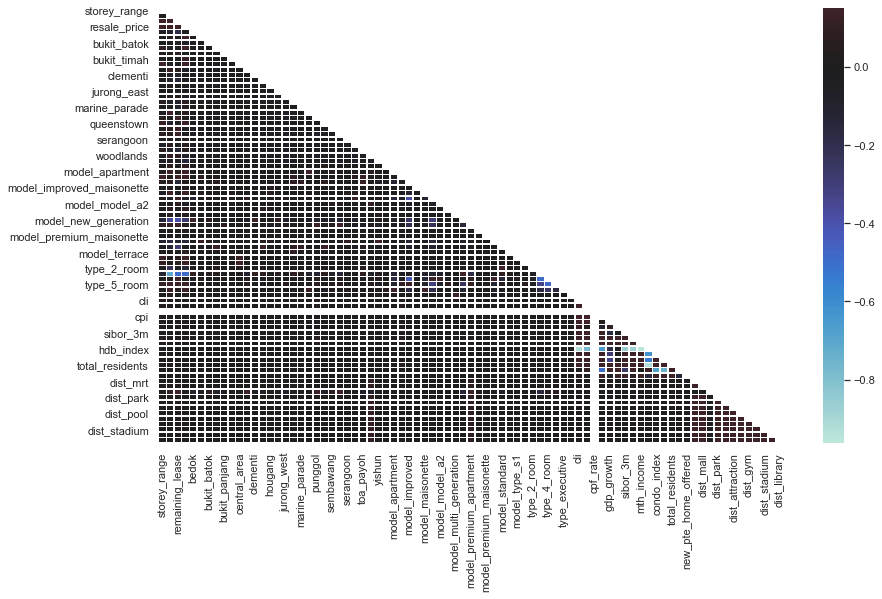

In [72]:
sns.set(style="white")
        
corr = hdb_df.corr()
fig,ax = plt.subplots(figsize=(14,8))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr,mask=mask,cbar=True,linewidths=0.5,square=False,vmax=.15, center=0)

In [140]:
hdb_df.to_csv("../datasets/hdb/reduced_features.csv",index=False)